In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

### CSCI 447 Fall 2023 Kaggle Competition

In [2]:
train = pd.read_csv('data/kaggle_train.csv')
test = pd.read_csv('data/kaggle_test.csv')
# example = pd.read_csv('data/kaggle_example_submission.csv')

In [ ]:
train

In [ ]:
# show features that correlate most with target
train.corr()['target'].sort_values(ascending=False)

---

In [ ]:
# # Remove features that correlate weakly with target (run this to do that)
# train_correlated = train.copy()
# train_correlated = train_correlated.drop(['f14', 'f13','f11'], axis=1)

# train = train_correlated

In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [ ]:
# get column names to re add after scaling
train_cols = train.columns
test_cols = test.columns

# get target col to re add after scaling
train_target = train['target']

# get id col to re add after scaling
train_id = train['id']
test_id = test['id']

In [ ]:
# standardize data
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler2 = StandardScaler()
train = scaler1.fit_transform(train)
test = scaler2.fit_transform(test)
train

In [ ]:
# add column names back
train = pd.DataFrame(train, columns=train_cols)
test = pd.DataFrame(test, columns=test_cols)
# add target col back
train['target'] = train_target
# add id col back
train['id'] = train_id
test['id'] = test_id
train

#### XGBoost:

In [4]:
# split data into train and test sets
X = train.drop(['target', 'id'], axis=1)
y = train['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', np.sqrt(mse))

RMSE: 4.106519076284248


In [ ]:
# # grid search on xgb
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# params = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [1, 2, 3, 4, 5],
#     'min_child_weight': [1, 2, 3],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.5, 0.75, 1],
#     'colsample_bytree': [0.5, 0.75, 1],
#     'reg_alpha': [0, 0.1, 0.2],
#     'reg_lambda': [0, 0.1, 0.2]
# }
# grid = GridSearchCV(estimator=xgb, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=1)
# # grid = RandomizedSearchCV(estimator=xgb, param_distributions=params, scoring='neg_mean_squared_error', cv=5, verbose=1)
# grid.fit(X_train, y_train)
# print(grid.best_params_)
# print(grid.best_score_)
# best_xgb = grid.best_estimator_
# y_pred = best_xgb.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print('MSE:', mse)

In [6]:
xgb_best_so_far = XGBRegressor(n_estimators=500, learning_rate=0.2, max_depth=1, min_child_weight=1, gamma=0, reg_lambda=0.1, subsample=1, colsample_bytree=0.5, reg_alpha=0, random_state=42)
xgb_best_so_far.fit(X_train, y_train)
y_pred = xgb_best_so_far.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', np.sqrt(mse))

RMSE: 2.5690158091286452


#### FEATURE ENGINEERING:

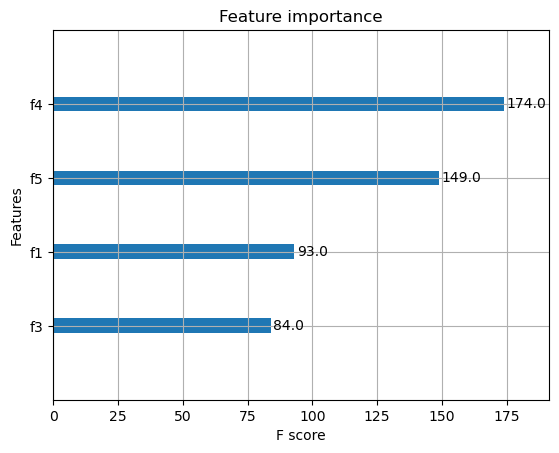

In [30]:
# find most important features
from xgboost import plot_importance
plot_importance(xgb_best_so_far)
plt.show()

In [29]:
train_reduced = train[['f4','f5','f1','f3','target']]

X = train_reduced.drop(['target'], axis=1)
y = train_reduced['target']

# add some polynomial features
# X['f1f3'] = X['f1'] * X['f3']

X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_best_so_far.fit(X_train_reduced, y_train_reduced)
y_pred = xgb_best_so_far.predict(X_test_reduced)
mse = mean_squared_error(y_test_reduced, y_pred)
print('RMSE:', np.sqrt(mse))
print('MSE:', mse)

RMSE: 1.8433906998835963
MSE: 3.398089272417335


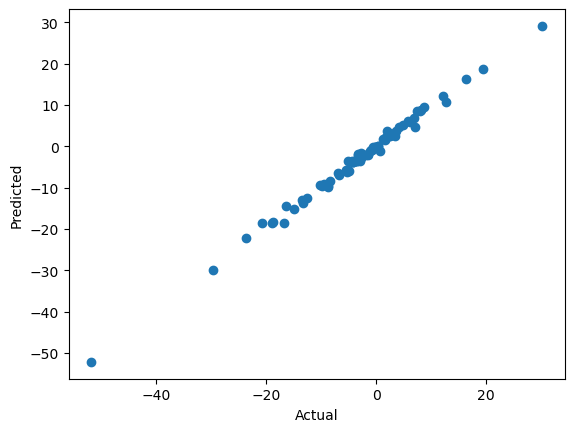

In [14]:
# plot predictions vs actual
plt.scatter(y_test_reduced, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [21]:
# predict test set and save to csv with ID, target
test_reduced = test[['id', 'f4','f5','f1','f3']]
test_reduced = test_reduced.drop(['id'], axis=1)
predictions = xgb_best_so_far.predict(test_reduced)
predictions = pd.DataFrame(predictions, columns=['target'])
predictions = pd.concat([test, predictions], axis=1)
# predictions = predictions[['target']]
predictions = predictions[['id', 'target']]
predictions

In [ ]:
predictions.to_csv('data/kaggle_submission_bova_5.csv', index=False)

---

## GMM

In [ ]:
# gaussian process regressor
from sklearn.gaussian_process import GaussianProcessRegressor

# [(1.0, SimpleRegressionPipeline({'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'no_preprocessing', 'regressor:__choice__': 'gaussian_process', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'most_frequent', 'data_preprocessor:feature_type:numerical_transformer:rescaling:__choice__': 'minmax', 'regressor:gaussian_process:alpha': 0.015101741903765523, 'regressor:gaussian_process:thetaL': 1.2894855172471412e-07, 'regressor:gaussian_process:thetaU': 57350.099005831544},
# dataset_properties={
#   'task': 4,
#   'sparse': False,
#   'multioutput': False,
#   'target_type': 'regression',
#   'signed': False}))]

from sklearn.gaussian_process.kernels import RBF, ConstantKernel
kernel = ConstantKernel() * RBF()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)
gpr.fit(X_train, y_train)
y_pred = gpr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('RMSE:', np.sqrt(mse))